# Data Preprocessing

## Importing / Installing packages

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt
from sqlalchemy import create_engine
import re

from sklearn.cluster import KMeans, k_means

%matplotlib inline

## Loading the Raw Data into Python

In [3]:
# Loading the data
connection_string = f"mysql+mysqlconnector://{'root'}:{'Ihatereading1'}@{'35.184.140.18'}:{'3306'}/{'WEB'}"
engine = create_engine(connection_string)
query = "select userInfo.*, sampleOption.*from users AS userInfo join options_selected AS sampleOption on userInfo.id = sampleOption.id;"
raw_data = pd.read_sql(query, engine)

# print the shape
print(raw_data.shape)

# run the first five rows
raw_data.head()

# save data
raw_data.to_excel("Official_Data.xlsx")

(15, 32)


##  Data Cleaning

In [4]:
# remove useless columns
data = raw_data.drop(['id', 'sample_options_id', 'start_time', 'end_time', 'states',
              'sample_1_text','sample_2_text','sample_3_text','sample_4_text','sample_5_text','sample_6_text',
              'sample_7_text','sample_8_text'], axis='columns')
print(data.shape)
data.head(1)

(15, 18)


,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
0,45-54,female,non hispanic,native american,High School,na,"$25,000 - $49,999",Employed Part time,both,i do not have a disability,Persuasive,Simplier,Empathetic,Persuasive,Original,Original,Persuasive,Original


### Clean Text

In [5]:
def clean_text(text):
    if text.strip().lower() == 'na' or not text.strip():
        cleaned_text = 'undisclosed'
    else:
        pattern = r'[^a-zA-Z0-9\s]'  # Keep letters, numbers, and spaces
        cleaned_text = re.sub(pattern, '', text.lower())
    return cleaned_text

In [6]:
def clean_income(income):
    if income.strip().lower() == 'na' or not income.strip():
        cleaned_income = 'undisclosed'
    else:
        cleaned_income = re.sub(r'[,$]', '', income)  # Remove commas and dollar signs
    return cleaned_income

In [7]:
def disability_status(disability_status):
    if disability_status.lower() == "i do not have a disability":
        return "no disability"
    elif disability_status.lower() == "i have a disability":
        return "has disability"
    elif disability_status.lower() == "na":
        return "undisclosed"
    else:
        return disability_status 

In [8]:
data.loc[:, 'ethnicity'] = data['ethnicity'].apply(clean_text)
data.loc[:, 'gender'] = data['gender'].apply(clean_text)
data.loc[:, 'race'] = data['race'].apply(clean_text)
data.loc[:, 'education'] = data['education'].apply(clean_text)
data.loc[:, 'marital_status'] = data['marital_status'].apply(clean_text)
data.loc[:, 'employment'] = data['employment'].apply(clean_text)
data.loc[:, 'language'] = data['language'].apply(clean_text)
data.loc[:, 'disability'] = data['disability'].apply(disability_status)

data.loc[:, 'income'] = data['income'].apply(clean_income)

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


### Data Encoding

In [9]:
def encode_income(income_category):
    income_encoding = {
        'Less than 25000': 0,
        '25000 - 49999': 1,
        '50000 - 74999': 2,
        '75000 - 99999': 3,
        '100000 - 149999': 4,
        '150000 or more': 5,
        'prefer not to say': 6
    }
    
    return income_encoding.get(income_category, -1)


def encode_age(age_group):
    age_encoding = {
        '18-24': 0,
        '25-34': 1,
        '35-44': 2,
        '45-54': 3,
        '55-64': 4,
        '65 and above': 5,
        'Prefer not to say': 6
    }
    
    return age_encoding.get(age_group, -1)

In [10]:
data['income'] = data['income'].apply(encode_income)
data['age'] = data['age'].apply(encode_age)
# data.head()

C:\Users\Owner\AppData\Local\Temp/ipykernel_7832/15651635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['income'] = data['income'].apply(encode_income)
C:\Users\Owner\AppData\Local\Temp/ipykernel_7832/15651635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'] = data['age'].apply(encode_age)


# Data Formats

## Data Form: Wide Format

In [11]:
wide_data = data.copy()
wide_data.head()

,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
0,3,female,non hispanic,native american,high school,undisclosed,1,employed part time,both,no disability,Persuasive,Simplier,Empathetic,Persuasive,Original,Original,Persuasive,Original
1,0,male,hispanic,white,high school,single,0,employed part time,english,no disability,Original,Simplier,Empathetic,Simplier,Simplier,Original,Original,Persuasive
2,1,female,non hispanic,multiracial,associate,single,0,student,english,no disability,Original,Original,Simplier,Simplier,Empathetic,Empathetic,Empathetic,Simplier
3,1,female,hispanic,undisclosed,associate,single,0,employed part time,both,no disability,Empathetic,Persuasive,Original,Original,Empathetic,Empathetic,Persuasive,Empathetic
4,0,male,hispanic,native american,bachelor,single,1,student,both,undisclosed,Empathetic,Persuasive,Original,Empathetic,Persuasive,Original,Empathetic,Empathetic


## Data Form: Frequency Count of Tonality Choices

In [12]:
frequency_data = data.copy()

In [13]:
tonality_columns = ['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8']
frequency_data['total_original'] = frequency_data[tonality_columns].eq('Original').sum(axis=1)
frequency_data['total_simplier'] = frequency_data[tonality_columns].eq('Simplier').sum(axis=1)
frequency_data['total_empathetic'] = frequency_data[tonality_columns].eq('Empathetic').sum(axis=1)
frequency_data['total_persuasive'] = frequency_data[tonality_columns].eq('Persuasive').sum(axis=1)

frequent_data = frequency_data.drop(tonality_columns, axis=1)
frequent_data.head()

,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,total_original,total_simplier,total_empathetic,total_persuasive
0,3,female,non hispanic,native american,high school,undisclosed,1,employed part time,both,no disability,3,1,1,3
1,0,male,hispanic,white,high school,single,0,employed part time,english,no disability,3,3,1,1
2,1,female,non hispanic,multiracial,associate,single,0,student,english,no disability,2,3,3,0
3,1,female,hispanic,undisclosed,associate,single,0,employed part time,both,no disability,2,0,4,2
4,0,male,hispanic,native american,bachelor,single,1,student,both,undisclosed,2,0,4,2


## Data Form: Melted Data

In [23]:
melted_data = data.copy()

keep_columns = ['age', 'gender', 'ethnicity', 'race', 'education', 'marital_status', 'income', 'employment', 'language', 'disability']

melted_data = pd.melt(melted_data, id_vars=keep_columns, value_vars=['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8'],
                      var_name='sample_number', value_name='choice')

melted_data['sample_number'] = melted_data['sample_number'].str.split('_').str[1].astype(int)

sample_numbers = pd.DataFrame({'sample_number': range(1, 9)})

final_data = melted_data.merge(sample_numbers, on='sample_number')

final_data = final_data.drop('sample_number', axis=1)
final_data.head()


,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,choice
0,3,female,non hispanic,native american,high school,undisclosed,1,employed part time,both,no disability,Persuasive
1,0,male,hispanic,white,high school,single,0,employed part time,english,no disability,Original
2,1,female,non hispanic,multiracial,associate,single,0,student,english,no disability,Original
3,1,female,hispanic,undisclosed,associate,single,0,employed part time,both,no disability,Empathetic
4,0,male,hispanic,native american,bachelor,single,1,student,both,undisclosed,Empathetic


# Encoding Data

## Label Encoder

In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_enc = frequent_data.copy()
label_enc = label_enc.apply(le.fit_transform)
label_enc.head()

,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,total_original,total_simplier,total_empathetic,total_persuasive
0,2,0,1,2,3,3,2,1,0,0,3,1,0,3
1,0,1,0,5,3,2,1,1,1,0,3,3,0,1
2,1,0,1,1,0,2,1,2,1,0,2,3,2,0
3,1,0,0,4,0,2,1,1,0,0,2,0,3,2
4,0,1,0,2,1,2,2,2,0,1,2,0,3,2


## Pandas Dummies

In [25]:
# features = ['age', 'gender', 'ethnicity', 'race', 'education', 'marital_status', 'income',
#             'employment', 'language','disability', 'choice']
features = ['age', 'gender', 'ethnicity', 'race', 'education', 'marital_status', 'income',
            'employment', 'language','disability','total_original', 'total_simplier', 'total_empathetic', 'total_persuasive']

original = frequent_data.copy()

pandas_enc = original[features]

pandas_enc = pd.get_dummies(pandas_enc, columns = features)

pandas_enc.head()

,age_0,age_1,age_3,gender_female,gender_male,gender_non binary,ethnicity_hispanic,ethnicity_non hispanic,race_mexican,race_multiracial,...,total_simplier_3,total_empathetic_1,total_empathetic_2,total_empathetic_3,total_empathetic_4,total_persuasive_0,total_persuasive_1,total_persuasive_2,total_persuasive_3,total_persuasive_4
0,0,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0
2,0,1,0,1,0,0,0,1,0,1,...,1,0,0,1,0,1,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [26]:
print(pandas_enc.shape)

(15, 56)


# Feature Scaling: Standardization/Normalization

The data already has a consistent scale, and all values fall within the same range (0 to 1). Therefore, [standardization](https://saturncloud.io/blog/how-to-normalize-columns-with-onehot-encoding-efficiently-in-pandas-dataframes/) (Z-score normalization) and normalization (Min-Max scaling) don't change the nature of the data.
>One issue with one-hot encoding is that it can lead to a high number of features, especially when dealing with datasets with many categorical variables. This can lead to a sparse matrix, which can be inefficient for analysis and modeling. To overcome this issue, we can normalize the one-hot encoded columns using the L1 or L2 norm. Normalizing the columns ensures that each feature has equal importance and reduces the dimensionality of the data.

**Normalization Types:**
* Manhattan normalization (l1): Scales each feature by the sum of its absolute values. This ensures that the sum of the absolute values of each feature is equal to 1.
* Euclidean normalization (L2): Scales each feature by its magnitude, which is the square root of the sum of its squared values. This ensures that the sum of the squared values of each feature is equal to 1.

## Standardize Data

In [27]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
scaled_data = scaler.fit_transform(pandas_enc)

## Normalize Data

In [28]:
from sklearn.preprocessing import normalize

normalized = normalize(scaled_data, norm='l2', axis=0) #l1, l2a

In [29]:
from sklearn.preprocessing import MinMaxScaler

data_scale = pandas_enc.copy()
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(data_scale)

# Feature selection
Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Effective feature selection can improve the efficiency and effectiveness of the machine learning or clustering models by reducing dimensionality and noise;speed up the learning algorithm; and improve the predictive accuracy.
<br>
<br>
1. Correlation-Based Feature Selection [Jaccard similarity](https://www.learndatasci.com/glossary/jaccard-similarity/#:~:text=The%20Jaccard%20similarity%20measures%20the,of%20observations%20in%20either%20set.): Measures the similarity between two sets of data to see which members are shared and distinct.The Jaccard Similarity will be 0 if the two sets don't share any values and 1 if the two sets are identical. In regards to my encoded categorical data, I want to:
* capture similarity and disimilarity between the sets of categories. 
* Identify which categorical features are similar in terms of their category membership, which can be used for dimensionality reduction (by selecting a subset of features that capture similar information).
2. [Variance Threshold](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/#:~:text=The%20variance%20threshold%20is%20a,same%20value%20in%20all%20samples.): The variance threshold is a simple baseline approach to feature selection. It removes all features whose variance doesn't meet some threshold. By default, it removes all zero-variance features, i.e., features with the same value in all samples. We assume that features with a higher variance may contain more useful information, but note that we are not taking the relationship between feature variables or feature and target variables into account, which is one of the drawbacks of filter methods.


## Jaccard Correlation

In [32]:
def jaccard_similarity(column1, column2):
    intersection = sum((column1 == 1) & (column2 == 1))
    union = sum((column1 == 1) | (column2 == 1))
    return intersection / union if union > 0 else 0

data_corr = pandas_enc.copy()
# Calculate Jaccard similarity between pairs of columns in 'data_corr'
correlation_matrix = pd.DataFrame(index=data_corr.columns, columns=data_corr.columns)

for col1 in data_corr.columns:
    for col2 in data_corr.columns:
        correlation_matrix.loc[col1, col2] = jaccard_similarity(data_corr[col1], data_corr[col2])

# Convert the correlation matrix to a DataFrame
correlation_df = pd.DataFrame(correlation_matrix, index=data_corr.columns, columns=data_corr.columns)

print(correlation_df)

                                    age_0     age_1     age_3 gender_female  \
age_0                                 1.0       0.0       0.0      0.153846   
age_1                                 0.0       1.0       0.0      0.636364   
age_3                                 0.0       0.0       1.0      0.090909   
gender_female                    0.153846  0.636364  0.090909           1.0   
gender_male                           0.5       0.0       0.2           0.0   
gender_non binary                     0.0     0.125       0.0           0.0   
ethnicity_hispanic               0.416667  0.428571  0.076923      0.466667   
ethnicity_non hispanic                0.0  0.222222      0.25           0.3   
race_mexican                          0.0     0.125       0.0           0.1   
race_multiracial                      0.0     0.125       0.0           0.1   
race_native american             0.142857       0.1      0.25      0.181818   
race_puerto rican                     0.0     0.125 

## VarianceThreshold

In [33]:
from sklearn.feature_selection import VarianceThreshold

enc_data = pandas_enc.copy()

# Create a VarianceThreshold selector
selector = VarianceThreshold(threshold=0.2)

# Fit data
selector.fit(enc_data)

X_selected = selector.transform(enc_data)

# -------------Testing Frequency Count of Tonality Choices Dataset-----------------

In [34]:
from sklearn.cluster import KMeans, k_means
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

In [35]:
pip install --upgrade threadpoolctl scikit-learn

In [36]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

## Clustering Algorithms
1. **K-Modes**: 
K-Modes is a clustering algorithm designed for categorical data, making it an excellent choice when working with non-numeric variables such as text data, categorical labels, or customer preferences. Unlike K-Means, which relies on numerical distance metrics, K-Modes employs a matching dissimilarity measure to cluster data points based on their categorical similarity. This makes it highly suitable for datasets with discrete features. K-Modes is particularly valuable when seeking interpretable cluster results, as each cluster's mode represents a typical categorical profile. It's robust against outliers and noise in categorical data and can handle large datasets efficiently. K-Modes is widely used in market segmentation, customer profiling, and any application where categorical variables play a crucial role in understanding underlying patterns and groupings within the data.
<br>
2. **K-Means**:K-Means is a versatile clustering algorithm that works well with numerical data, providing a way to partition data points into distinct clusters based on their numerical feature values. It relies on minimizing the sum of squared distances between data points and the centroid of their assigned cluster. K-Means is widely used in various fields, such as image segmentation, customer segmentation, and anomaly detection.
<br>
3. **Hierarchical Clustering**:Hierarchical Clustering is a versatile clustering technique used to group data points into a hierarchical tree-like structure, or dendrogram, based on their similarity or dissimilarity. It's applicable to various data types, including numerical, categorical, and even text data, making it a flexible choice for many clustering scenarios.Hierarchical clustering doesn't require specifying the number of clusters beforehand, which can be advantageous when the optimal number of clusters is unclear. It can reveal the natural hierarchy within the data, allowing for exploration at different granularity levels.
<br>

## Cluster Analysis Techniques
**Elbow Method**
The elbow point is where the within-cluster sum of squares (WCSS) starts to level off or bend. <br>
<br>
**Silhoette Score Analysis** The silhouette score measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, with higher values indicating that objects are well matched to their own clusters and poorly matched to neighboring clusters. Here's what different silhouette score values imply:

* A score close to +1 indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. This suggests a good, distinct cluster.

* A score around 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters. This typically occurs when there is overlapping between clusters.

* A score close to -1 indicates that the object is incorrectly assigned to a neighboring cluster rather than its own. This suggests poor clustering.

**Cophenetic Correlation**:
<br>
The [Cophenetic Correlation]() Coefficient (CPCC) is a measure used to assess how well a hierarchical clustering algorithm/dendrogram preserves the pairwise distances between data points during the clustering process.
<br>
**How it works**:
<br>
1. Develope the dendrogram
2. The algorithm computes a matrix of pairwise distances between all data points before clustering
3. The CPCC is calculated by comparing the pairwise distances in the dendrogram.
4. The CPCC value ranges between -1 and 1:
* A CPCC close to 1 indicates that the dendrogram preserves the original distances well, suggesting that the clustering captures the underlying structure of the data.
* A CPCC close to 0 suggests that the dendrogram does not preserve the original distances well.
* A negative CPCC indicates that the dendrogram is worse than random at preserving distances.

# Original Data

## 1. K-Modes (Not Encoded)

In [37]:
frequent_data.head(2)

,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,total_original,total_simplier,total_empathetic,total_persuasive
0,3,female,non hispanic,native american,high school,undisclosed,1,employed part time,both,no disability,3,1,1,3
1,0,male,hispanic,white,high school,single,0,employed part time,english,no disability,3,3,1,1


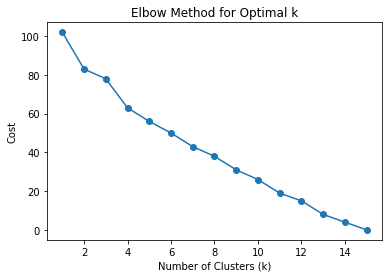

In [38]:
import matplotlib.pyplot as plt

costs = []
K_range = range(1, 16)
for k in K_range:
    k_modes = KModes(n_clusters=k)
    k_modes.fit(frequent_data)
    costs.append(k_modes.cost_)

plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [39]:
# Implement K-Modes and assign 4 as the optimal number of customers
original = frequent_data.copy()
k = 4
km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=1)

# Fit the model to the data
clusters = km.fit_predict(original)

original['Cluster'] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2, cost: 71.0
Run 1, iteration: 2/100, moves: 0, cost: 71.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1, cost: 66.0
Run 2, iteration: 2/100, moves: 0, cost: 66.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 69.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 68.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 78.0
Best run was number 2


## Silhouette Score for K-Modes

In [40]:
# Compute the silhouette score using Jaccard distance,Jaccard distance metric is often used
# for categorical data
silhouette_avg = silhouette_score(pandas_enc, clusters, metric='jaccard')
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.11833051344301677


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


## Dataframe w/ cluster assignments

In [41]:
original.head(2)

,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,total_original,total_simplier,total_empathetic,total_persuasive,Cluster
0,3,female,non hispanic,native american,high school,undisclosed,1,employed part time,both,no disability,3,1,1,3,3
1,0,male,hispanic,white,high school,single,0,employed part time,english,no disability,3,3,1,1,1


## 2. K-Means

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

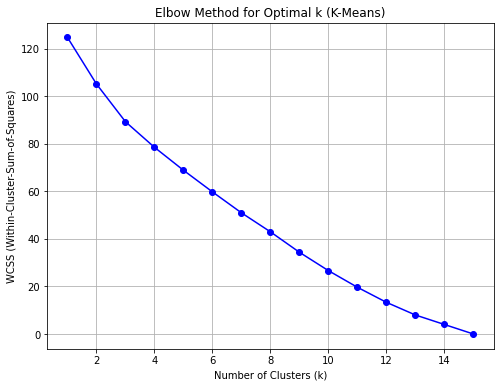

In [42]:
from sklearn.cluster import KMeans
wcss = []
# Original dataset encoded to run on K-Means
# Try different values of k (number of clusters)
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pandas_enc)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster-Sum-of-Squares)')
plt.grid(True)
plt.show()

## Silhouette Score

In [43]:
%%time
kmeans = KMeans(n_clusters=3).fit_predict(pandas_enc)
print(silhouette_score(pandas_enc, kmeans))

0.07466047347546946
Wall time: 44 ms


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# --------------------------------------Encoded Data---------------------------------

In [44]:
pandas_enc.head(2)

,age_0,age_1,age_3,gender_female,gender_male,gender_non binary,ethnicity_hispanic,ethnicity_non hispanic,race_mexican,race_multiracial,...,total_simplier_3,total_empathetic_1,total_empathetic_2,total_empathetic_3,total_empathetic_4,total_persuasive_0,total_persuasive_1,total_persuasive_2,total_persuasive_3,total_persuasive_4
0,0,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0


## 1. K-Modes

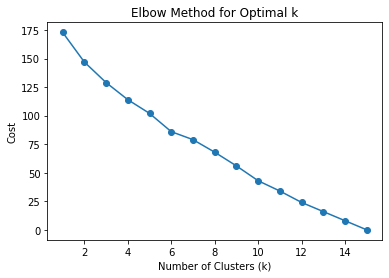

In [45]:
import matplotlib.pyplot as plt

costs = []
K_range = range(1, 16)
for k in K_range:
    k_modes = KModes(n_clusters=k)
    k_modes.fit(pandas_enc)
    costs.append(k_modes.cost_)

plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

## 3. Hierarchical Clustering

### Dendrogram

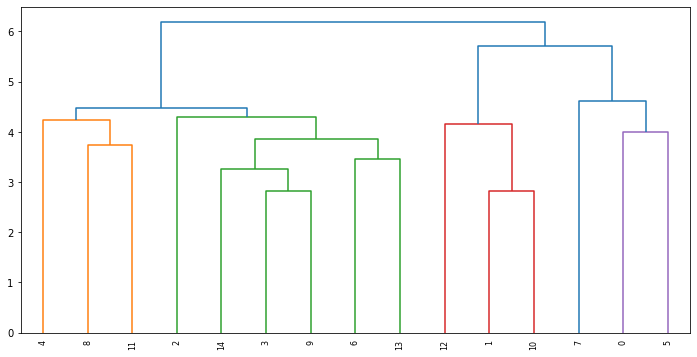

In [46]:
linkage_matrix = linkage(pandas_enc, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=8.)
plt.show()

## AgglomerativeClustering

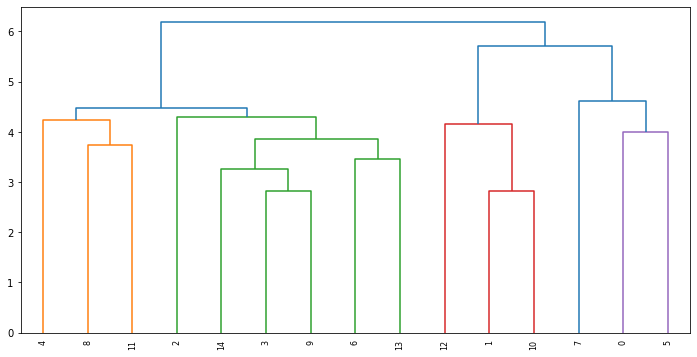

In [47]:
# model
model = AgglomerativeClustering(n_clusters=4, linkage='ward')
clusters = model.fit_predict(pandas_enc)

# linkage matrix
linkage_matrix = linkage(pandas_enc, method='ward')

# plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, leaf_rotation=90., leaf_font_size=8.)
plt.show()

In [48]:
agg_clusters = pandas_enc.copy()

agg_clusters['cluster'] = clusters

In [49]:
agg_clusters.head()

,age_0,age_1,age_3,gender_female,gender_male,gender_non binary,ethnicity_hispanic,ethnicity_non hispanic,race_mexican,race_multiracial,...,total_empathetic_1,total_empathetic_2,total_empathetic_3,total_empathetic_4,total_persuasive_0,total_persuasive_1,total_persuasive_2,total_persuasive_3,total_persuasive_4,cluster
0,0,0,1,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
1,1,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,2
2,0,1,0,1,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


##  Cophenetic Correlation Coefficient (CPCC)

In [50]:
coph_corr, _ = cophenet(linkage_matrix, pdist(pandas_enc))
print(f"Cophenetic Correlation Coefficient: {coph_corr}")

Cophenetic Correlation Coefficient: 0.725512370960267


# ---Applying VarianceThreshold---

## 1. K-Modes

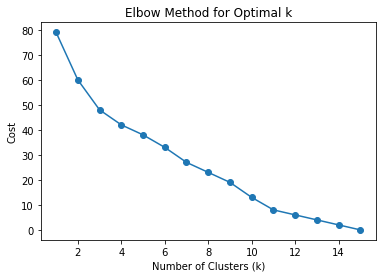

In [51]:
import matplotlib.pyplot as plt

costs = []
K_range = range(1, 16)
for k in K_range:
    k_modes = KModes(n_clusters=k)
    k_modes.fit(X_selected)
    costs.append(k_modes.cost_)

plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

## 2. K-Means

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

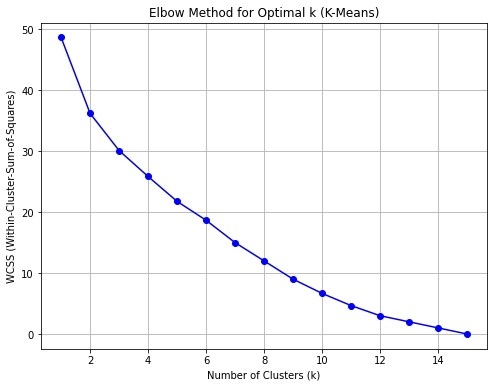

In [52]:
from sklearn.cluster import KMeans
wcss = []

# Try different values of k (number of clusters)
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_selected)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster-Sum-of-Squares)')
plt.grid(True)
plt.show()

In [53]:
%%time
kmeans = KMeans(n_clusters=4).fit_predict(X_selected)
print(silhouette_score(X_selected,kmeans))

0.14093035920996105
Wall time: 45 ms


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## 3. Hierarchical Clustering

In [ ]:
linkage_matrix1 = linkage(X_selected, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix1, leaf_rotation=90., leaf_font_size=8.)
plt.show()

In [ ]:
#  Cut the dendrogram to get the clusters
# Set the threshold or number of clusters
threshold = 3  # Adjust this value according to your dendrogram
clusters = fcluster(linkage_matrix1, threshold, criterion='distance')
clusters

##  Cophenetic Correlation Coefficient (CPCC)

In [ ]:
coph_corr, _ = cophenet(linkage_matrix1, pdist(X_selected))
print(f"Cophenetic Correlation Coefficient: {coph_corr}")

## 4. AgglomerativeClustering

In [ ]:
# model
model = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters = model.fit_predict(X_selected)

# linkage matrix
linkage_matrix2 = linkage(X_selected, method='ward')

# plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix2, leaf_rotation=90., leaf_font_size=8.)
plt.show()

##  Cophenetic Correlation Coefficient (CPCC)

In [ ]:
coph_corr1, _ = cophenet(linkage_matrix2, pdist(X_selected))
print(f"Cophenetic Correlation Coefficient: {coph_corr1}")

# Visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------Features--------
categorical_vars = ['age', 'gender', 'ethnicity', 'race', 'education', 'marital_status',
       'income', 'employment', 'language', 'disability', 'choice']

num_clusters = len(data['cluster'].unique())
fig, axes = plt.subplots(1, len(categorical_vars), figsize=(6 * len(categorical_vars), 6))

for i, var in enumerate(categorical_vars):
    cross_tab = pd.crosstab(data['cluster'], data[var])

    # ------stacked bar chart--------
    ax = cross_tab.plot(kind='bar', stacked=True, alpha=0.8)

    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.set_title(f'{var} Distribution by Cluster')
    ax.legend(title=var, loc='upper right')

    plt.savefig(f'{var}_distribution.png', bbox_inches='tight') 
    plt.clf() 

plt.tight_layout()
